In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os

import numpy as np
import matplotlib.pyplot as plt

from NormalizingFlows.src.train import train_backward
from NormalizingFlows.src.scores import log_likelihood
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model

from NormalizingFlows.src.flows import *
from NormalizingFlows.src.data.density.toydata import ToyDataset

In [3]:
def set_visible_devices(*devices: int) -> None:
    '''Utility to set visible Cuda devices.

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.
    '''
    assert all([d >= 0 for d in devices]), f"Not all devices are CUDA devices!"
    os.environ['CUDA_VISIBLE_DEVICES'] = ",".join([str(i) for i in devices])
    

def set_devices(*devices: int):
    '''Utility to set Cuda device(s).

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.

    Returns
    -------
    torch.device or List[torch.device] of currently available CUDA devices.
    '''
    assert len(devices) > 0, f'Device list is empty, no devices set.'
    if len(devices) == 1:
        if devices[0] >= 0:
            set_visible_devices(devices[0])
            return torch.device(0)
        else:
            return torch.device('cpu')

    else:
        set_visible_devices(*devices)
        return [torch.device(i) for i in range(len(devices))]

In [4]:
device = set_devices(1) #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [5]:
dim_input = 25
dataset = ToyDataset(dim_input=dim_input, samples=10000)

dim_input = dataset.dim_input
num_trans = 6 #Must be even
perm_types = ['identity', 'alternate','random']
dim_hidden = [100,100,100]
flows = {}
flow_forward = False


epochs = 15
batch_size = 32
num_exp = 5

In [6]:
# #Linear and mean field

# transformations = create_constant_trans(num_trans, dim_input, flow_forward)
# mean_field = create_flows_with_identity(dim_input, transformations, flow_forward) 
# name = 'Mean field'
# flows.append(mean_field), names.append(name)

# transformations = create_linear_bias_trans(num_trans, dim_input, flow_forward)
# linear = create_flows_with_identity(dim_input, transformations, flow_forward)
# name = 'Linear'
# flows.append(linear), names.append(name);

In [7]:
# #Affine flows with two block

# name = 'Affine coupling identity'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affine_trans(num_trans, flow_forward, a_param=F.softplus)
#     aff_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
#     flows[name] += [aff_coup_id]
#     flows[name][-1].name = f'{name} {i}'

# name = 'Affine coupling alternating'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affine_trans(num_trans, flow_forward, a_param=F.softplus)
#     aff_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
#     flows[name] += [aff_coup_alt]
#     flows[name][-1].name = f'{name} {i}'
    
# name = 'Affine coupling random'
# flows[name] = []
# for i in range(num_exp):
#     transformations = create_affine_trans(num_trans, flow_forward, a_param=F.softplus)
#     aff_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
#     flows[name] += [aff_coup_rand]
#     flows[name][-1].name = f'{name} {i}'

In [8]:
#Affine flows with AR

name = 'Affine AR identity'
flows[name] = []
for i in range(num_exp):
    transformations = create_affine_trans(num_trans, flow_forward)
    aff_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
    flows[name] += [aff_ar_id]
    flows[name][-1].name = f'{name} {i}'

name = 'Affine AR alternate'
flows[name] = []
for i in range(num_exp):
    transformations = create_affine_trans(num_trans, flow_forward)
    aff_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
    flows[name] += [aff_ar_alt]
    flows[name][-1].name = f'{name} {i}'

name = 'Affine AR random'
flows[name] = []
for i in range(num_exp):
    transformations = create_affine_trans(num_trans, flow_forward)
    aff_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
    flows[name] += [aff_ar_rand]
    flows[name][-1].name = f'{name} {i}'


In [9]:
# #PiecewiseAffine flows with coupling

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffine coupling identity'
# flows.append(piec_coup_id), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffine coupling alternate'
# flows.append(piec_coup_alt), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffine coupling random'
# flows.append(piec_coup_rand), names.append(name);

In [10]:
# #PiecewiseAffine flows with AR

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffine AR identity'
# flows.append(piec_ar_id), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffine AR alternate'
# flows.append(piec_ar_alt), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffine AR random'
# flows.append(piec_ar_rand), names.append(name);

In [11]:
# #PiecewiseAffineAffine with twoblock

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffineAffine coupling identity'
# flows.append(piecaf_coup_id), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine coupling alternate'
# flows.append(piecaf_coup_alt), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine coupling random'
# flows.append(piecaf_coup_rand), names.append(name);

In [12]:
# #PiecewiseAffineAffine with AR

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffineAffine AR identity'
# flows.append(piecaf_ar_id), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine AR alternate'
# flows.append(piecaf_ar_alt), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffineAffine AR random'
# flows.append(piecaf_ar_rand), names.append(name);

In [13]:
# #ContinuousPiecewise with twoblock

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling identity'
# flows.append(conpiec_coup_iden), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling alternate'
# flows.append(conpiec_coup_alt), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling random'
# flows.append(conpiec_coup_rand), names.append(name);

In [14]:
# #ContinuousPiecewise with AR

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffine AR identity'
# flows.append(conpiec_ar_iden), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffine AR alternate'
# flows.append(conpiec_ar_alt), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffine AR random'
# flows.append(conpiec_ar_rand), names.append(name);

In [15]:
# #ContinuousPiecewiseAffine with twoblock

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling identity'
# flows.append(affconpiec_coup_iden), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling alternate'
# flows.append(affconpiec_coup_alt), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling random'
# flows.append(affconpiec_coup_rand), names.append(name);

In [16]:
# #ContinuousPiecewiseAffine with AR

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR identity'
# flows.append(affconpiec_ar_iden), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR alternate'
# flows.append(affconpiec_ar_alt), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR random'
# flows.append(affconpiec_ar_rand), names.append(name);

In [17]:
# #Alternating Piecewise Affine with twoblock

# transformations = create_alt_piecewise_affine_trans(num_trans, flow_forward)
# afpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Affin_PiecewiseAffine coupling random'
# flows.append(afpiec_coup_rand), names.append(name);

In [18]:
# #Alternating Piecewise Affine with AR

# transformations = create_alt_piecewise_affine_trans(num_trans, flow_forward)
# afpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Affin_PiecewiseAffine AR random'
# flows.append(afpiec_ar_rand), names.append(name);

In [19]:
# #Alternating with Linear layer and Affine

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Alternating Linear_Affine coupling identity'
# flows.append(linaff_coup_iden), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_Affine coupling random'
# flows.append(linaff_coup_rand), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Alternating Linear_Affine AR identity'
# flows.append(linaff_ar_iden), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_Affine AR random'
# flows.append(linaff_ar_rand), names.append(name);

In [20]:
# #Various Alternating Linear and Conditioner transformation

# transformations = create_alt_linear_piecewise_trans(num_trans, dim_input, flow_forward)
# linpiece_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_PiecewiseAffine coupling random'
# flows.append(linpiece_coup_rand), names.append(name)

# transformations = create_alt_linear_continuous_trans(num_trans, dim_input, flow_forward)
# lincont_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_ContinuousPiece coupling random'
# flows.append(lincont_coup_rand), names.append(name)

# transformations = create_alt_linear_affinepiecewise_trans(num_trans, dim_input, flow_forward)
# linaffpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_AffinePiece coupling random'
# flows.append(linaffpiec_coup_rand), names.append(name)

# transformations = create_alt_linear_affinecontinuous_trans(num_trans, dim_input, flow_forward)
# linaffcont_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_AffineContinuous coupling random'
# flows.append(linaffcont_coup_rand), names.append(name);

In [21]:
losses = {n: [] for n in flows.keys()}
optimizers = {n: [] for n in flows.keys()}

for flowname in flows.keys():
    for j in range(num_exp):
        # Initialize flow
        flow = flows[flowname][j]
        update_device(device, flow, dataset)

        # Initialize optimizer
        optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-4, weight_decay=1e-2)
        optimizers[flowname].append(optimizer)
        
        # Train and append losses
        losses[flowname].append(
            train_backward(
                flow, 
                dataset.get_training_data(), 
                optimizer, 
                epochs, 
                batch_size, 
                print_n=200, 
                save_checkpoint=True, 
                burn_in=-1
            )
        )

        # Move flow to CPU
        update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch Affine AR random 4:     46.54233


In [22]:
best_flows = {n:[] for n in flows.keys()}
for flowname in flows.keys():
    for i in range(num_exp):
        best_flows[flowname].append(load_best_model(flows[flowname][i]))

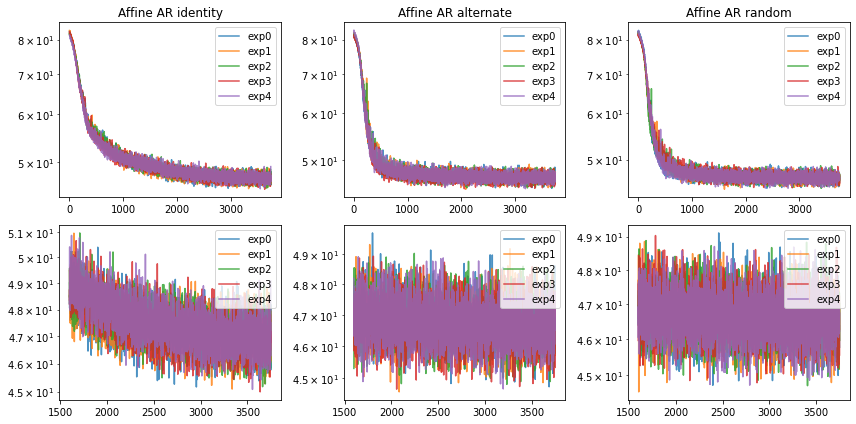

In [23]:
log_scale = True
from_iter = 50 * batch_size

fig, ax = plt.subplots(2, len(flows), figsize=(12,6))
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        ax[0,j].plot(losses[flowname][i], label=f'exp{i}', alpha=0.8)
        ax[0,j].set_title(f'{flowname}')
        if log_scale:
            ax[0, j].set_yscale('log')
        ax[0, j].legend()

log_scale = True
for j, flowname in enumerate(flows.keys()):
    for i in range(num_exp):
        x = np.arange(len(losses[flowname][i]))
        ax[1,j].plot(x[from_iter:], losses[flowname][i][from_iter:], label=f'exp{i}', alpha=0.8)
        if log_scale:
            ax[1, j].set_yscale('log')
        ax[1, j].legend()
    
plt.tight_layout()

In [24]:
flow_lh_results = {
    'train': {n:[] for n in flows}, 
    'test': {n:[] for n in flows}, 
    'sample': {n:[] for n in flows},
}
cur_res = 'train'

print('Results based on training data:' + '\n')

# Function for CI
def mean_confidence_interval(data, confidence=0.95):
    import scipy.stats
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
 

train_data = dataset.get_training_data()
mean_target = torch.mean(dataset.evaluate(train_data.to(device))).detach().numpy()
for flow in best_flows:
    for i in range(num_exp):
        log_lik, mean = log_likelihood(train_data, flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))
        print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on training data:

Mean loglikelihood for Affine AR identity 0: [-46.807343]
Difference between target and Affine AR identity mean loglikelihood: [0.34996033]

Mean loglikelihood for Affine AR identity 1: [-46.858322]
Difference between target and Affine AR identity mean loglikelihood: [0.40093994]

Mean loglikelihood for Affine AR identity 2: [-46.893074]
Difference between target and Affine AR identity mean loglikelihood: [0.43569183]

Mean loglikelihood for Affine AR identity 3: [-46.80536]
Difference between target and Affine AR identity mean loglikelihood: [0.34797668]

Mean loglikelihood for Affine AR identity 4: [-46.853905]
Difference between target and Affine AR identity mean loglikelihood: [0.39652252]

---------------------------------------------------------------------------
Affine AR identity -- Mean LogLH Bootstrap: -46.8436 ±  0.0462
---------------------------------------------------------------------------

Mean loglikelihood for Affine AR alternate 0: [

In [25]:
print('Results based on test data' + '\n')
cur_res = 'test' 

test_data = dataset.get_test_data()
mean_target = torch.mean(dataset.evaluate(test_data)).detach().numpy()
for flow in best_flows:
    for i in range(num_exp):
        log_lik, mean = log_likelihood(test_data, flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))
        print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

# for flow in best_flows:
#     log_lik, mean = log_likelihood(test_data, flow)
#     print("Mean loglikelihood for {}: {}".format(str(flow), mean))
#     print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    

# print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on test data

Mean loglikelihood for Affine AR identity 0: [-46.913445]
Difference between target and Affine AR identity mean loglikelihood: [0.49069595]

Mean loglikelihood for Affine AR identity 1: [-46.960552]
Difference between target and Affine AR identity mean loglikelihood: [0.53780365]

Mean loglikelihood for Affine AR identity 2: [-47.004517]
Difference between target and Affine AR identity mean loglikelihood: [0.58176804]

Mean loglikelihood for Affine AR identity 3: [-46.89231]
Difference between target and Affine AR identity mean loglikelihood: [0.46956253]

Mean loglikelihood for Affine AR identity 4: [-46.95357]
Difference between target and Affine AR identity mean loglikelihood: [0.53082275]

---------------------------------------------------------------------------
Affine AR identity -- Mean LogLH Bootstrap: -46.9449 ±  0.0542
---------------------------------------------------------------------------

Mean loglikelihood for Affine AR alternate 0: [-46.67

In [26]:
print('Results based on new sample from each flow:' + '\n')
cur_res = 'sample'

for flow in best_flows:
    for i in range(num_exp):
        with torch.no_grad():
            sample, log_prob = flows[flow][i].sample(800)
            sample_last = sample[-1]

        mean_target = torch.mean(dataset.evaluate(sample_last)).detach().numpy()
        log_lik, mean = log_likelihood(sample_last, flows[flow][i])
        flow_lh_results[cur_res][flow].append(mean[0])
        print("Mean loglikelihood for {}: {}".format(f'{flow} {i}', mean))
        print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
        print("Mean loglikelihood with actual distribution: {}".format(mean_target))   
        print()
    
    m, h = mean_confidence_interval(flow_lh_results[cur_res][flow])
    print('-'*75)
    print(f'{flow} -- Mean LogLH Bootstrap: {m:7.4f} ± {h:7.4f}')
    print('-'*75)
    print()


# for flow in best_flows:
#     with torch.no_grad():
#         sample, log_prob = flow.sample(800)
#         sample_last = sample[-1]

#     #sample_last.clip_(-7, 7)
#     mean_target = torch.mean(dataset.evaluate(sample_last)).detach().numpy()
#     log_lik, mean = log_likelihood(sample_last, flow)

#     print('Check for NANs: ', torch.isnan(sample_last).any().item())
#     print("Mean loglikelihood for {}: {}".format(str(flow), mean))
#     print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))    
#     print("Mean loglikelihood with actual distribution: {}".format(mean_target))   

Results based on new sample from each flow:

Mean loglikelihood for Affine AR identity 0: [-47.17668]
Difference between target and Affine AR identity mean loglikelihood: [0.63349915]
Mean loglikelihood with actual distribution: -47.8101806640625

Mean loglikelihood for Affine AR identity 1: [-47.16073]
Difference between target and Affine AR identity mean loglikelihood: [0.5849228]
Mean loglikelihood with actual distribution: -47.74565124511719

Mean loglikelihood for Affine AR identity 2: [-47.157772]
Difference between target and Affine AR identity mean loglikelihood: [0.7787323]
Mean loglikelihood with actual distribution: -47.93650436401367

Mean loglikelihood for Affine AR identity 3: [-47.01754]
Difference between target and Affine AR identity mean loglikelihood: [0.4862938]
Mean loglikelihood with actual distribution: -47.50383377075195

Mean loglikelihood for Affine AR identity 4: [-47.10626]
Difference between target and Affine AR identity mean loglikelihood: [0.7678528]
Mean